In [1]:
import torch as t
import torch.nn as nn
import torch.nn.functional as f

import matplotlib.pyplot as plt
t.set_default_device('mps')

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/torch/autograd/__init__.py:251: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


0.5000028014183044
0.3435509204864502
0.10862623155117035
0.07161346077919006
tensor(0.0688, device='mps:0', grad_fn=<MeanBackward0>)


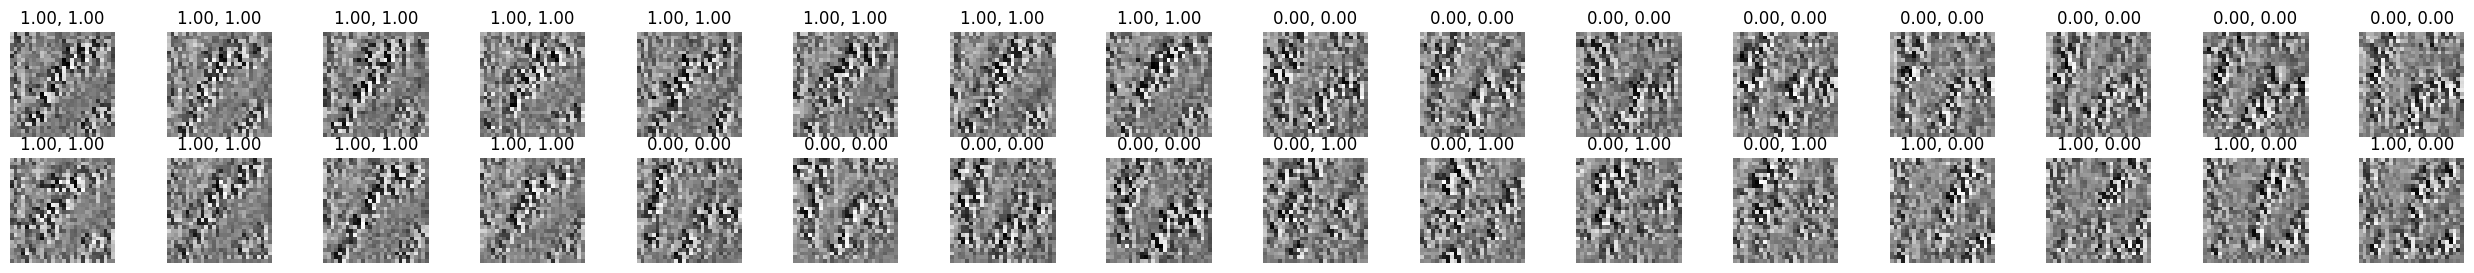

torch.Size([512, 32, 787])
torch.Size([512, 32, 2])


In [2]:
class cnvs(nn.Module):
    def __init__(self, bs, ch=4):
        super().__init__()
        self.c1 = nn.Conv2d(bs, bs*ch, 3, groups=bs)
        self.c2 = nn.Conv2d(bs*ch, bs*ch, 3, groups=bs)
        self.c3 = nn.Conv2d(bs*ch, bs*ch, 3, groups=bs)
        self.a = nn.ReLU()
        self.m = nn.MaxPool2d(2)
        self.l = nn.Parameter(t.randn(2, bs, 16*ch))
        self.s = nn.Sigmoid()
        self.bs = bs
    
    def forward(self, x):
        x = self.m(self.a(self.c1(x)))
        x = self.m(self.a(self.c2(x)))
        x = self.a(self.c3(x))
        x = x.view(x.shape[0], self.bs, -1)
        x = t.einsum('abc,dbc->bad', x, self.l)
        x = self.s(x)
        return x


sn = 32
bs = 512

mod = cnvs(bs)
dist = t.rand(sn, bs, 28, 28)
# pad with zeros
dat = t.zeros(sn, bs, 32, 32)
dat[:, :, 2:30, 2:30] = dist / 8
dat.requires_grad = True

oneone1 = t.tensor([1,1], dtype=t.float32).expand(sn//4, 2)
zerozero1 = t.tensor([0,0], dtype=t.float32).expand(sn//4, 2)
oneone2 = t.tensor([1,1], dtype=t.float32).expand(sn//8, 2)
zerozero2 = t.tensor([0,0], dtype=t.float32).expand(sn//8, 2)
zeroone = t.tensor([0,1], dtype=t.float32).expand(sn//8, 2)
onezero = t.tensor([1,0], dtype=t.float32).expand(sn//8, 2)
lbl = t.cat([oneone1, zerozero1, oneone2, zerozero2, zeroone, onezero], dim=0)
lbl = lbl.repeat(bs, 1, 1)

loss = nn.L1Loss()
opt = t.optim.Adam([dat, *mod.parameters()], lr=0.02)

l = 0
for i in range(20):
    opt.zero_grad()
    out = mod(dat)
    l = loss(out, lbl)
    l.backward()
    opt.step()
    if i % 5 == 0:
        print(l.item())
print(l)

y = mod(dat).detach().view(bs, sn, 2)[0].cpu().numpy()
data = dat[:, :, 2:30, 2:30]
img = data[:, 0, :, :].detach().cpu().numpy()
fig, axs = plt.subplots(2, sn//2, figsize=(sn, 3))
for i in range(sn//2):
    # cmap for rgb
    axs[0, i].imshow(img[i], cmap='gray')
    axs[0, i].axis('off')
    axs[0, i].set_title(f"{y[i][0]:.2f}, {y[i][1]:.2f}")
for i in range(sn//2, sn):
    axs[1, i-sn//2].imshow(img[i], cmap='gray')
    axs[1, i-sn//2].axis('off')
    axs[1, i-sn//2].set_title(f"{y[i][0]:.2f}, {y[i][1]:.2f}")
plt.show()

data = t.permute(t.flatten(data, 2), (1, 0, 2))
labs = mod(dat).detach().view(bs, sn, 2).detach()

lebs = t.cat([labs[:, :sn//2, :], t.ones(bs, sn//2, 1)], dim=2)
lebs = t.cat([lebs, t.zeros(bs, sn//2, 3)], dim=1)
data = t.cat([data, lebs], dim=2)

print(data.shape)
print(labs.shape)


In [3]:
# create a transformer
class trans(nn.Module):
    def __init__(self, dm=800):
        super().__init__()
        self.inbed = nn.Linear(787, dm)
        self.think = nn.TransformerEncoderLayer(d_model=dm, nhead=1)
        self.thinker = nn.TransformerEncoder(self.think, num_layers=4)
        self.out = nn.Linear(dm, 2)
    def forward(self, x):
        x = self.inbed(x)
        x = self.thinker(x)
        return self.out(x)


In [4]:
learner = trans()
print(learner(t.randn(32, 100, 787)).shape)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


torch.Size([32, 100, 2])


In [5]:


sn = 32
bs = 512

oneone1 = t.tensor([1,1], dtype=t.float32).expand(sn//4, 2)
zerozero1 = t.tensor([0,0], dtype=t.float32).expand(sn//4, 2)
oneone2 = t.tensor([1,1], dtype=t.float32).expand(sn//8, 2)
zerozero2 = t.tensor([0,0], dtype=t.float32).expand(sn//8, 2)
zeroone = t.tensor([0,1], dtype=t.float32).expand(sn//8, 2)
onezero = t.tensor([1,0], dtype=t.float32).expand(sn//8, 2)
lbl = t.cat([oneone1, zerozero1, oneone2, zerozero2, zeroone, onezero], dim=0)
lbl = lbl.repeat(bs, 1, 1)

total_params = sum(p.numel() for p in learner.parameters() if p.requires_grad)
print(f"Number of trainable parameters in the learner model: {total_params}")


loss = nn.L1Loss()
optz = t.optim.Adam(learner.parameters(), lr=0.001)


Number of trainable parameters in the learner model: 29862242


In [6]:
def lossr(outputs, labels):
    # try both permutations of features A and B
    loss1 = t.mean(t.mean(t.abs(outputs - labels), dim=2), dim=1)
    loss2 = t.mean(t.mean(t.abs(outputs @ t.tensor([[0, 1], [1, 0]], dtype=t.float32) - labels), dim=2), dim=1)
    loss_stack = t.stack([loss1, loss2], dim=1)
    losser = t.min(loss_stack, dim=1).values
    losser = t.mean(losser)
    
    return losser
testout = t.tensor([[[1, 1], [0, 0], [0, .1], [0, 0]]], dtype=t.float32)
testlbl = t.tensor([[[1, 1], [0, 0], [1, 0], [0, 1]]], dtype=t.float32)
print(lossr(testout, testlbl))

tensor(0.2375, device='mps:0')


In [8]:

learner.load_state_dict(t.load("./checkpoints/overnight_19688.pt")['model_state_dict'])
optz.load_state_dict(t.load("./checkpoints/overnight_19688.pt")['optimizer_state_dict'])


In [9]:
for n in range(1, 10):
    mod = cnvs(bs)
    dist = t.rand(sn, bs, 28, 28)
    dat = t.zeros(sn, bs, 32, 32)
    dat[:, :, 2:30, 2:30] = dist / 8
    dat.requires_grad = True

    opt = t.optim.Adam([dat, *mod.parameters()], lr=0.02)

    l = 0
    for i in range(20):
        opt.zero_grad()
        out = mod(dat)
        l = loss(out, lbl)
        l.backward()
        opt.step()

    data = dat[:, :, 2:30, 2:30]
    data = t.permute(t.flatten(data, 2), (1, 0, 2))
    labs = mod(dat).detach().view(bs, sn, 2).detach()
    lebs = t.cat([labs[:, :sn//2, :], t.ones(bs, sn//2, 1)], dim=2)
    lebs = t.cat([lebs, t.zeros(bs, sn//2, 3)], dim=1)
    data = t.cat([data, lebs], dim=2)

    optz.zero_grad()
    outp = learner(data)
    l = lossr(outp, labs)
    l.backward()
    optz.step()

    # add learner loss to tensorboard

    if n % 107 == 0:
        print(l.item())
        t.save({
            'step': n,
            'model_state_dict': learner.state_dict(),
            'optimizer_state_dict': optz.state_dict(),
            'loss': l,
            }, f'overnight_{n}.pt')



0.5000264644622803
0.3452422320842743
0.11759375035762787
0.08237085491418839
tensor(0.0776, device='mps:0', grad_fn=<MeanBackward0>)
tensor([[1.0000e+00, 1.0000e+00],
        [1.0000e+00, 1.0000e+00],
        [1.0000e+00, 1.0000e+00],
        [1.0000e+00, 1.0000e+00],
        [1.0000e+00, 1.0000e+00],
        [1.0000e+00, 1.0000e+00],
        [1.0000e+00, 1.0000e+00],
        [1.0000e+00, 1.0000e+00],
        [1.2274e-17, 4.9882e-15],
        [3.8137e-16, 4.3332e-16],
        [3.7030e-17, 1.0374e-15],
        [5.9790e-18, 1.5662e-14],
        [1.5134e-15, 5.8040e-14],
        [3.2136e-17, 3.8460e-15],
        [9.2549e-16, 1.2311e-14],
        [2.6027e-17, 2.8957e-15]], device='mps:0')
(32, 28, 28)
(32, 2)


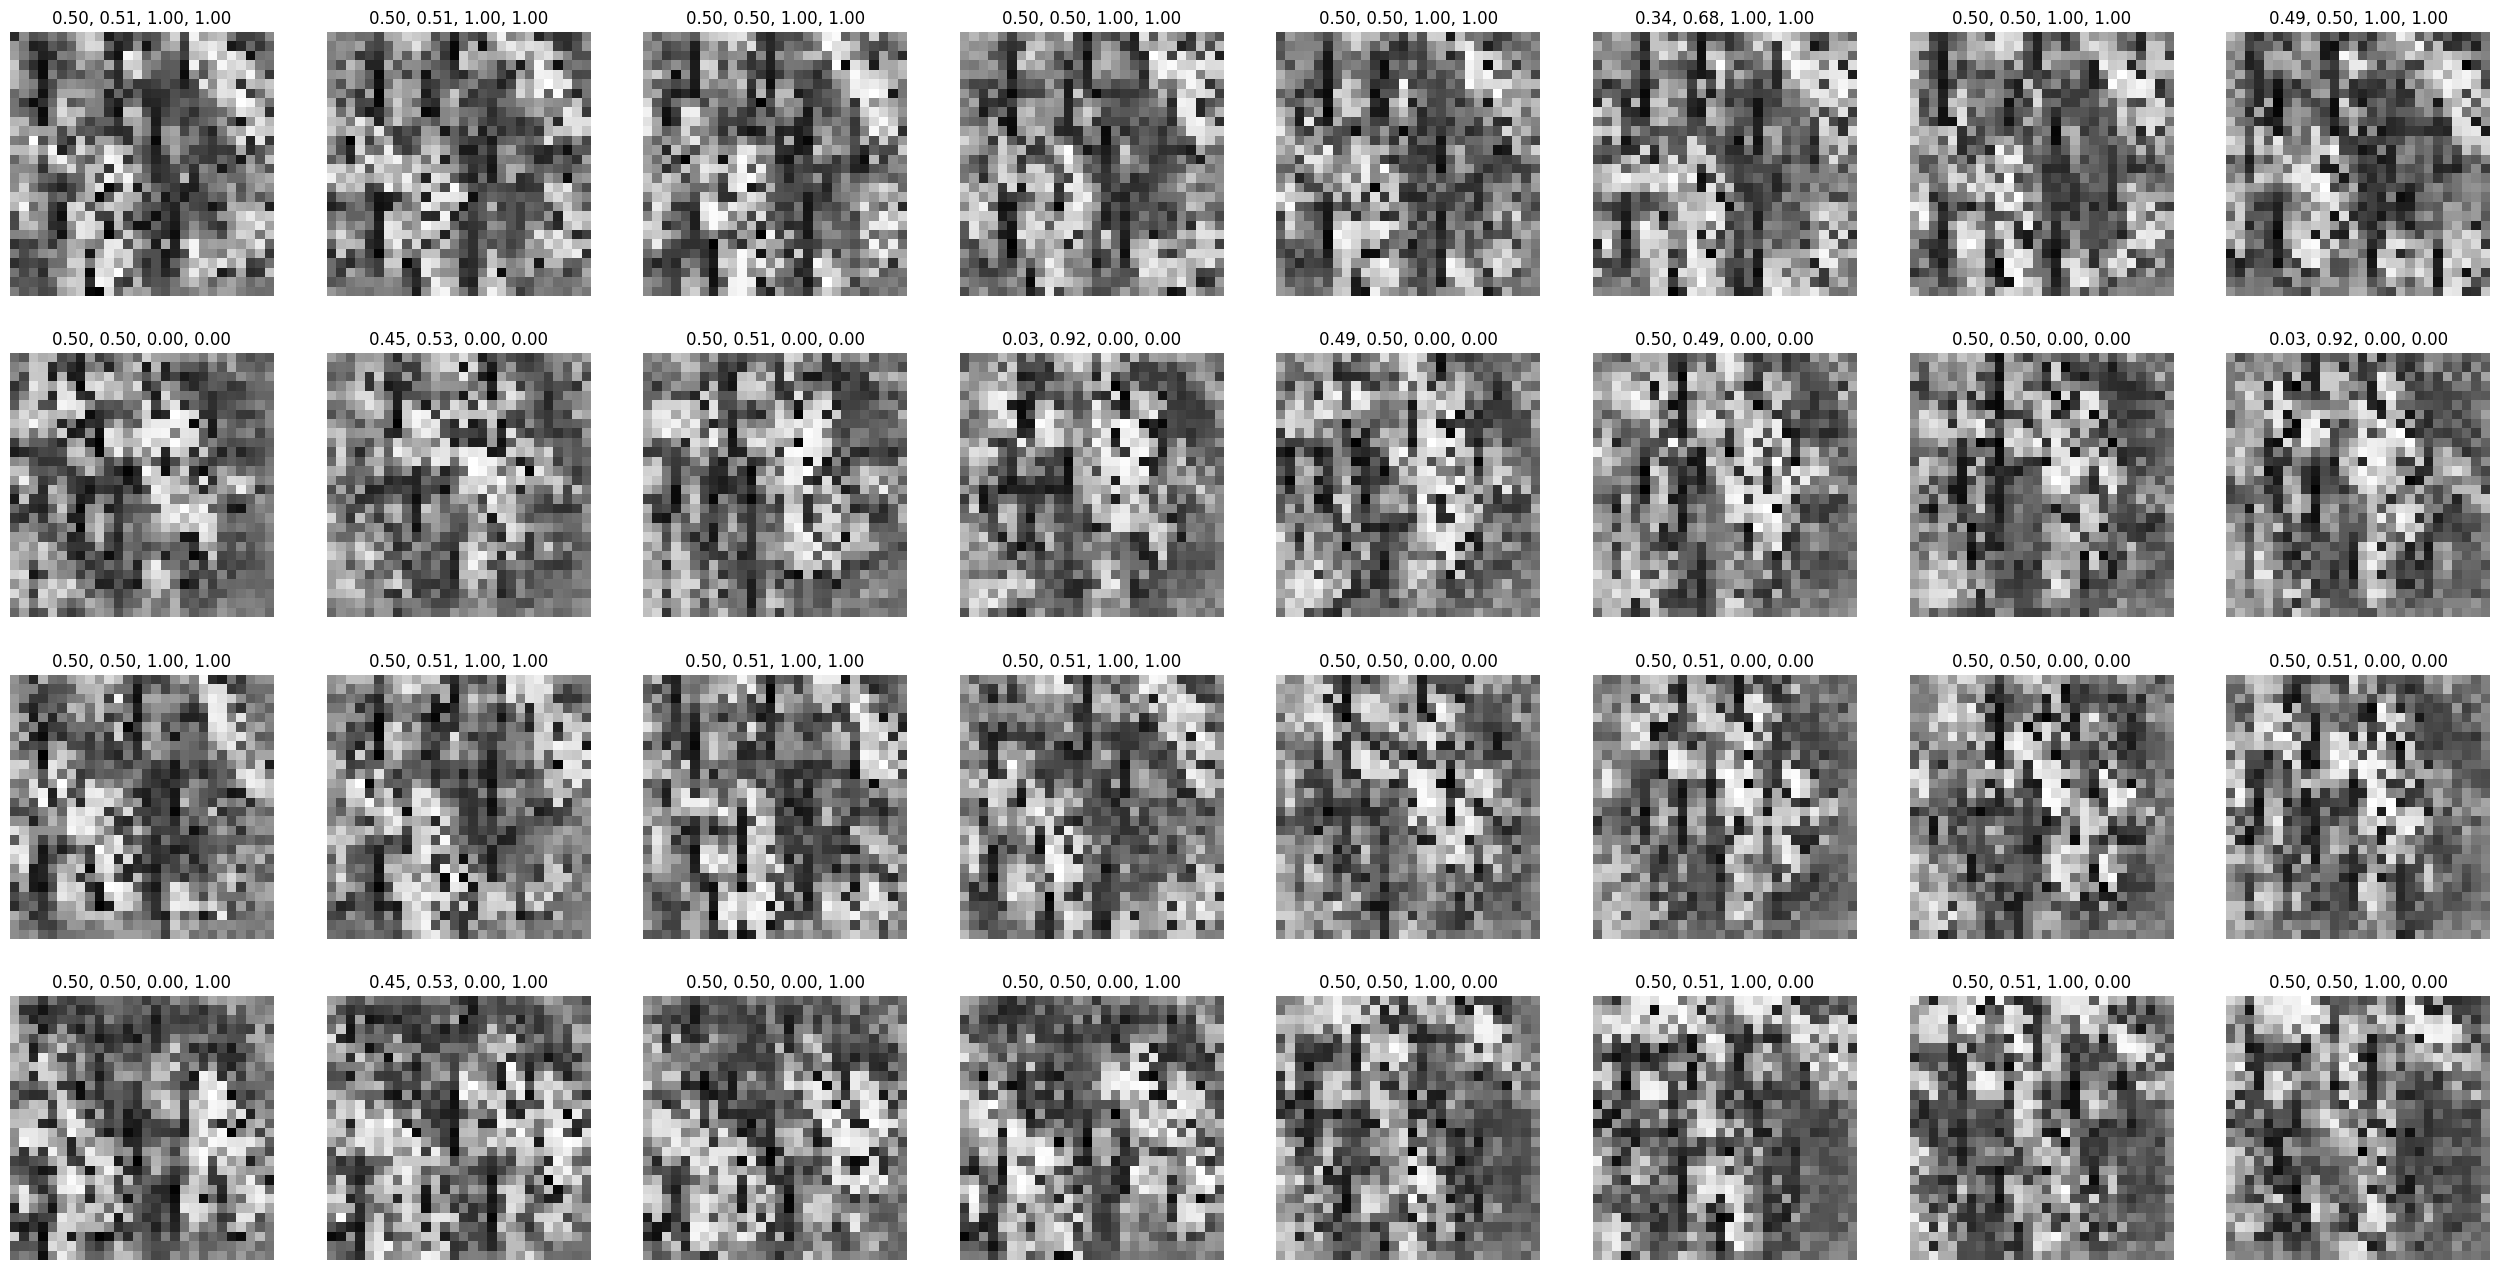

In [10]:

mod = cnvs(bs)
dist = t.rand(sn, bs, 28, 28)
# pad with zeros
dat = t.zeros(sn, bs, 32, 32)
dat[:, :, 2:30, 2:30] = dist / 8
dat.requires_grad = True

oneone1 = t.tensor([1,1], dtype=t.float32).expand(sn//4, 2)
zerozero1 = t.tensor([0,0], dtype=t.float32).expand(sn//4, 2)
oneone2 = t.tensor([1,1], dtype=t.float32).expand(sn//8, 2)
zerozero2 = t.tensor([0,0], dtype=t.float32).expand(sn//8, 2)
zeroone = t.tensor([0,1], dtype=t.float32).expand(sn//8, 2)
onezero = t.tensor([1,0], dtype=t.float32).expand(sn//8, 2)
lbl = t.cat([oneone1, zerozero1, oneone2, zerozero2, zeroone, onezero], dim=0)
lbl = lbl.repeat(bs, 1, 1)

lossy = nn.L1Loss()
opty = t.optim.Adam([dat, *mod.parameters()], lr=0.02)

l = 0
for i in range(20):
    opty.zero_grad()
    out = mod(dat)
    l = lossy(out, lbl)
    l.backward()
    opty.step()
    if i % 5 == 0:
        print(l.item())
print(l)



data = dat[:, :, 2:30, 2:30]
img = data[:, 0, :, :].detach().cpu().numpy()
data = t.permute(t.flatten(data, 2), (1, 0, 2))
labs = mod(dat).detach().view(bs, sn, 2).detach()
print(labs[0, :sn//2, :])
lebs = t.cat([labs[:, :sn//2, :], t.ones(bs, sn//2, 1)], dim=2)
lebs = t.cat([lebs, t.zeros(bs, sn//2, 3)], dim=1)
data = t.cat([data, lebs], dim=2)

y = learner(data)[0].detach().cpu().numpy()

print(img.shape)
print(y.shape)

fig, axs = plt.subplots(4, sn//4, figsize=(sn, 16))
for i in range(sn//4):
    # cmap for rgb
    axs[0, i].imshow(img[i], cmap='gray')
    axs[0, i].axis('off')
    axs[0, i].set_title(f"{y[i][0]:.2f}, {y[i][1]:.2f}, {lbl[0][i][0]:.2f}, {lbl[0][i][1]:.2f}")
for i in range(sn//4, sn//2):
    axs[1, i-sn//4].imshow(img[i], cmap='gray')
    axs[1, i-sn//4].axis('off')
    axs[1, i-sn//4].set_title(f"{y[i][0]:.2f}, {y[i][1]:.2f}, {lbl[0][i][0]:.2f}, {lbl[0][i][1]:.2f}")
for i in range(sn//2, sn//2 + sn//4):
    axs[2, i-sn//2].imshow(img[i], cmap='gray')
    axs[2, i-sn//2].axis('off')
    axs[2, i-sn//2].set_title(f"{y[i][0]:.2f}, {y[i][1]:.2f}, {lbl[0][i][0]:.2f}, {lbl[0][i][1]:.2f}")
for i in range(sn//2 + sn//4, sn):
    axs[3, i-(sn//2 + sn//4)].imshow(img[i], cmap='gray')
    axs[3, i-(sn//2 + sn//4)].axis('off')
    axs[3, i-(sn//2 + sn//4)].set_title(f"{y[i][0]:.2f}, {y[i][1]:.2f}, {lbl[0][i][0]:.2f}, {lbl[0][i][1]:.2f}")

plt.show()